In [31]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
from torch.optim import Adam
from tqdm import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#### This is the cointegrated/rubert-tiny model fine-tuned for classification of toxicity and inappropriateness for short informal Russian texts, such as comments in social networks. 
Initially the model has 5 classes, I will change this model to divide it into two classes 

In [3]:
sentiment = pipeline('text-classification', model='cointegrated/rubert-tiny-toxicity')

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [4]:
sentiment('Этот ресторан отличный')

[{'label': 'non-toxic', 'score': 0.9993882179260254}]

#### Data load

In [5]:
DATA_ROOT = 'D:/Data/Study/twitter_sentiment_analysis_via_RNN_GRU_LSTM/'

In [6]:
df_train = pd.read_csv(DATA_ROOT + 'train.csv')
df_val = pd.read_csv(DATA_ROOT + 'val.csv')
df_test = pd.read_csv(DATA_ROOT + 'test.csv')

In [7]:
df_train.shape

(181467, 3)

In [8]:
df_train.head(5)

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


array([<AxesSubplot:ylabel='class'>], dtype=object)

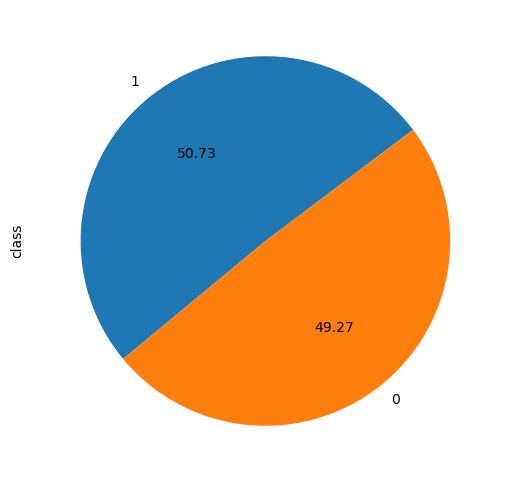

In [9]:
df_train['class'].value_counts().plot.pie(subplots=True,  autopct='%.2f', startangle=37, figsize=(11, 6))

#### Tokenization of texts

In [10]:
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny-toxicity')

In [11]:
example_text = 'Пример текста для токенизации'
auto_input = tokenizer(example_text, padding='max_length', max_length=10, 
                       truncation=True, return_tensors='pt')

In [12]:
print(auto_input['input_ids'])
print(auto_input['attention_mask'])

tensor([[    2,  3086, 10885, 22723,   871, 24302,  3464, 10880,     3,     0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])


In [13]:
#tokenizer.get_vocab()

In [14]:
example_text = tokenizer.decode(auto_input.input_ids[0])

In [15]:
print(example_text)

[CLS] Пример текста для токенизации [SEP] [PAD]


#### Wrapper over data

In [16]:
class TwitterDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self._labels = labels
        self.tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny-toxicity')
        self._texts = [self.tokenizer(text, padding='max_length', max_length=10, 
                                     truncation=True, return_tensors='pt')
                      for text in texts]
    
    def __len__(self):
        return len(self._texts)
    
    
    def __getitem__(self, index):
        return self._texts[index], self._labels[index]

In [17]:
y_train = df_train['class'].values
y_val = df_val['class'].values

train_dataset = TwitterDataset(df_train['text'], y_train)
valid_dataset = TwitterDataset(df_val['text'], y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=8,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=8,
                                           shuffle=False)

In [18]:
for txt, lbl in train_loader:
    print(txt.keys())
    print(txt['input_ids'].shape)
    break

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
torch.Size([8, 1, 10])


#### Initialization texts classification model

In [19]:
class TextClassificationModel(nn.Module):
    def __init__(self, dropout=0.1):
        super().__init__()
        self.bert = 
        AutoModelForSequenceClassification.from_pretrained('cointegrated/rubert-tiny-toxicity', 
                                                           return_dict=True).bert
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(312, 2)
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        pooled_output = self.bert(input_ids, 
                                  attention_mask=attention_mask, 
                                  token_type_ids=token_type_ids)['pooler_output']
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [20]:
model = TextClassificationModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.classifier.parameters(), lr=0.001)

In [21]:
print(model)

TextClassificationModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_a

In [22]:
print('Full train parameters:', sum([param.nelement() for param in model.parameters()]))
print('Transfer learning parameters:', sum([param.nelement() for param in model.classifier.parameters()]))


Full train parameters: 11784794
Transfer learning parameters: 626


#### Predictions on all df_val on the untrained model. Calculation of the quality metric on the untrained model.

In [24]:
model.eval()
total_loss_val, total_acc_val = 0.0, 0.0
for val_input, val_label in valid_loader:
    val_label = val_label.to(device)
    mask = val_input['attention_mask'].to(device)
    input_id = val_input['input_ids'].squeeze(1).to(device)

    output = model(input_id, mask)

    batch_loss = criterion(output, val_label)
    total_loss_val += batch_loss.item()

    acc = (output.argmax(dim=1) == val_label).sum().item()
    total_acc_val += acc
print(
    f'------------Untrained Model-------------\n'
    f'| Val Loss: {total_loss_val / len(valid_dataset): .3f}' 
    f'| Val Accuracy: {total_acc_val / len(valid_dataset): .3f}')

------------Untrained Model-------------
| Val Loss:  0.090| Val Accuracy:  0.507


#### Training the text classification model

In [40]:
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch_num in range(10):
    total_acc_train = 0
    total_loss_train =0
    
    model.train()
    for train_input, train_label in tqdm(train_loader):
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)
        train_label = train_label.to(device)
        
        output = model(input_id, mask)
        
        batch_loss = criterion(output, train_label)
        total_loss_train += batch_loss.item()
        
        acc = (output.argmax(dim=1) == train_label).sum().item()
        total_acc_train += acc
        
        model.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    model.eval()
    total_loss_val, total_acc_val = 0.0, 0.0
    for val_input, val_label in valid_loader:
        val_label = val_label.to(device)
        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)
        
        output = model(input_id, mask)
        
        batch_loss = criterion(output, val_label)
        total_loss_val += batch_loss.item()
        
        acc = (output.argmax(dim=1) == val_label).sum().item()
        total_acc_val += acc
    print(
        f'Epochs:{epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f}' 
        f'| Train Accuracy: {total_acc_train / len(train_dataset): .3f}' 
        f'| Val Loss: {total_loss_val / len(valid_dataset): .3f}' 
        f'| Val Accuracy: {total_acc_val / len(valid_dataset): .3f}')
    train_loss.append(total_loss_train / len(train_dataset))
    train_acc.append(total_acc_train / len(train_dataset))
    val_loss.append(total_loss_val / len(valid_dataset))
    val_acc.append(total_acc_val / len(valid_dataset))

100%|████████████████████████████████████████████████████████████████████████████| 22684/22684 [05:22<00:00, 70.40it/s]


Epochs:1 | Train Loss:  0.088| Train Accuracy:  0.535| Val Loss:  0.085| Val Accuracy:  0.562


100%|████████████████████████████████████████████████████████████████████████████| 22684/22684 [05:22<00:00, 70.24it/s]


Epochs:2 | Train Loss:  0.088| Train Accuracy:  0.533| Val Loss:  0.090| Val Accuracy:  0.506


100%|████████████████████████████████████████████████████████████████████████████| 22684/22684 [05:21<00:00, 70.61it/s]


Epochs:3 | Train Loss:  0.088| Train Accuracy:  0.536| Val Loss:  0.088| Val Accuracy:  0.527


100%|████████████████████████████████████████████████████████████████████████████| 22684/22684 [05:22<00:00, 70.42it/s]


Epochs:4 | Train Loss:  0.088| Train Accuracy:  0.534| Val Loss:  0.086| Val Accuracy:  0.563


100%|█████████████████████████████████████████████████████████████████████████| 22684/22684 [11:44:47<00:00,  1.86s/it]


Epochs:5 | Train Loss:  0.088| Train Accuracy:  0.535| Val Loss:  0.086| Val Accuracy:  0.553


100%|████████████████████████████████████████████████████████████████████████████| 22684/22684 [07:01<00:00, 53.86it/s]


Epochs:6 | Train Loss:  0.088| Train Accuracy:  0.534| Val Loss:  0.090| Val Accuracy:  0.520


100%|████████████████████████████████████████████████████████████████████████████| 22684/22684 [06:07<00:00, 61.72it/s]


Epochs:7 | Train Loss:  0.088| Train Accuracy:  0.534| Val Loss:  0.089| Val Accuracy:  0.497


100%|████████████████████████████████████████████████████████████████████████████| 22684/22684 [05:32<00:00, 68.26it/s]


Epochs:8 | Train Loss:  0.088| Train Accuracy:  0.537| Val Loss:  0.086| Val Accuracy:  0.528


100%|████████████████████████████████████████████████████████████████████████████| 22684/22684 [05:41<00:00, 66.48it/s]


Epochs:9 | Train Loss:  0.088| Train Accuracy:  0.536| Val Loss:  0.090| Val Accuracy:  0.523


100%|████████████████████████████████████████████████████████████████████████████| 22684/22684 [05:40<00:00, 66.70it/s]


Epochs:10 | Train Loss:  0.088| Train Accuracy:  0.536| Val Loss:  0.086| Val Accuracy:  0.554


#### Evaluation of the obtained results of model training

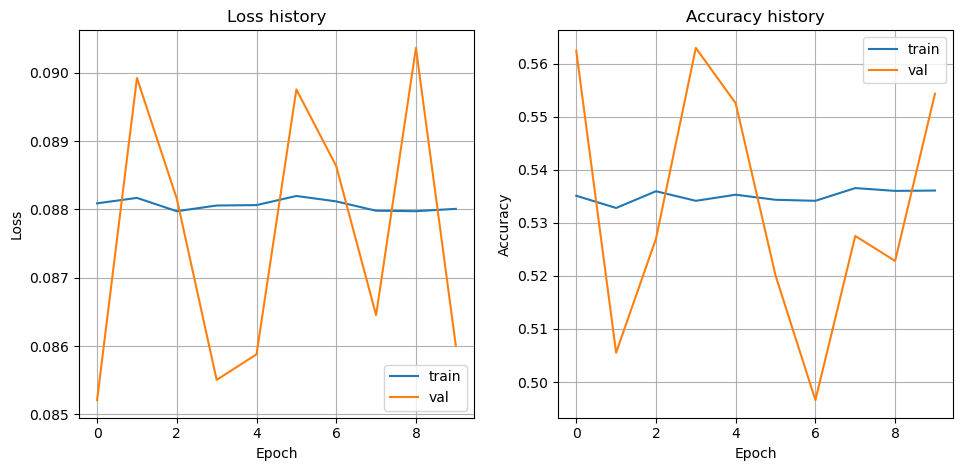

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)

ax1.set_title('Loss history')
ax1.grid(True)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.plot(train_loss, label='train')
ax1.plot(val_loss, label='val')
ax1.legend();

ax2.set_title('Accuracy history')
ax2.grid(True)
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.plot(train_acc, label='train')
ax2.plot(val_acc, label='val')
ax2.legend();

plt.show();

#### From the graphs you can see that the model did not train well on the unprocessed data, let's take the pre-processed data using the written handler from Lesson 7

In [59]:
df_train = pd.read_csv(DATA_ROOT + 'train_preprocess.csv')
df_val = pd.read_csv(DATA_ROOT + 'val_preprocess.csv')
df_test = pd.read_csv(DATA_ROOT + 'test_preprocess.csv')

In [60]:
df_train.shape

(181467, 4)

In [61]:
df_train.head(5)

,Unnamed: 0,id,text,class
0,0,0,неуезжаааааааать нехотеть уезжать,0
1,1,1,ребята девчата кино любовь завтра вотэтолюбовь,1
2,2,2,ненавидеть пробка ретвит,0
3,3,3,хотеться котлета покиевск запретный плод,1
4,4,4,босапоп есбосой небояться мороз,1


In [62]:
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny-toxicity')

In [63]:
class TwitterDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self._labels = labels
        self.tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny-toxicity')
        self._texts = [self.tokenizer(text, padding='max_length', max_length=18, 
                                     truncation=True, return_tensors='pt')
                      for text in texts]
    
    def __len__(self):
        return len(self._texts)
    
    
    def __getitem__(self, index):
        return self._texts[index], self._labels[index]

In [64]:
y_train = df_train['class'].values
y_val = df_val['class'].values

train_dataset = TwitterDataset(str(df_train['text']), y_train)
valid_dataset = TwitterDataset(str(df_val['text']), y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=8,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=8,
                                           shuffle=False)

In [65]:
model = TextClassificationModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.classifier.parameters(), lr=0.001)

#### Predictions on all df_val_preprocess on the untrained model. Calculation of the quality metric on the untrained model

In [66]:
model.eval()
total_loss_val, total_acc_val = 0.0, 0.0
for val_input, val_label in valid_loader:
    val_label = val_label.to(device)
    mask = val_input['attention_mask'].to(device)
    input_id = val_input['input_ids'].squeeze(1).to(device)

    output = model(input_id, mask)

    batch_loss = criterion(output, val_label)
    total_loss_val += batch_loss.item()

    acc = (output.argmax(dim=1) == val_label).sum().item()
    total_acc_val += acc
print(
    f'------------Untrained Model-------------\n'
    f'| Val Loss: {total_loss_val / len(valid_dataset): .3f}' 
    f'| Val Accuracy: {total_acc_val / len(valid_dataset): .3f}')

------------Untrained Model-------------
| Val Loss:  0.094| Val Accuracy:  0.493


#### Training the text classification model

In [68]:
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for epoch_num in range(7):
    total_acc_train = 0
    total_loss_train =0
    
    model.train()
    for train_input, train_label in tqdm(train_loader):
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)
        train_label = train_label.to(device)
        
        output = model(input_id, mask)
        
        batch_loss = criterion(output, train_label)
        total_loss_train += batch_loss.item()
        
        acc = (output.argmax(dim=1) == train_label).sum().item()
        total_acc_train += acc
        
        model.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    model.eval()
    total_loss_val, total_acc_val = 0.0, 0.0
    for val_input, val_label in valid_loader:
        val_label = val_label.to(device)
        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)
        
        output = model(input_id, mask)
        
        batch_loss = criterion(output, val_label)
        total_loss_val += batch_loss.item()
        
        acc = (output.argmax(dim=1) == val_label).sum().item()
        total_acc_val += acc
    print(
        f'Epochs:{epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f}' 
        f'| Train Accuracy: {total_acc_train / len(train_dataset): .3f}' 
        f'| Val Loss: {total_loss_val / len(valid_dataset): .3f}' 
        f'| Val Accuracy: {total_acc_val / len(valid_dataset): .3f}')
    train_loss.append(total_loss_train / len(train_dataset))
    train_acc.append(total_acc_train / len(train_dataset))
    val_loss.append(total_loss_val / len(valid_dataset))
    val_acc.append(total_acc_val / len(valid_dataset))

100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:02<00:00, 39.93it/s]


Epochs:1 | Train Loss:  0.088| Train Accuracy:  0.526| Val Loss:  0.096| Val Accuracy:  0.507


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 55.40it/s]


Epochs:2 | Train Loss:  0.090| Train Accuracy:  0.541| Val Loss:  0.097| Val Accuracy:  0.493


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 58.76it/s]


Epochs:3 | Train Loss:  0.089| Train Accuracy:  0.509| Val Loss:  0.089| Val Accuracy:  0.507


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 62.35it/s]


Epochs:4 | Train Loss:  0.087| Train Accuracy:  0.531| Val Loss:  0.089| Val Accuracy:  0.507


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 62.82it/s]


Epochs:5 | Train Loss:  0.088| Train Accuracy:  0.518| Val Loss:  0.091| Val Accuracy:  0.507


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 62.97it/s]


Epochs:6 | Train Loss:  0.089| Train Accuracy:  0.509| Val Loss:  0.088| Val Accuracy:  0.509


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:01<00:00, 62.69it/s]


Epochs:7 | Train Loss:  0.089| Train Accuracy:  0.511| Val Loss:  0.091| Val Accuracy:  0.507


#### Evaluation of the obtained results of model training

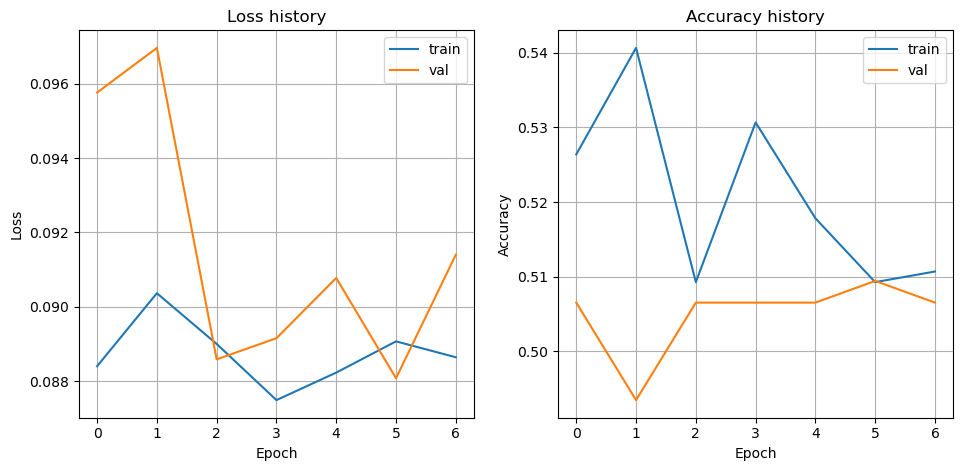

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)

ax1.set_title('Loss history')
ax1.grid(True)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.plot(train_loss, label='train')
ax1.plot(val_loss, label='val')
ax1.legend();

ax2.set_title('Accuracy history')
ax2.grid(True)
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.plot(train_acc, label='train')
ax2.plot(val_acc, label='val')
ax2.legend();

plt.show();